In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import h5py


In [5]:
with h5py.File('train_catvnoncat.h5', 'r') as f:
    X_orig = np.array(f['train_set_x'][:])  # (209, H, W, 3)
    y_orig = np.array(f['train_set_y'][:])  # (209,)

print("Original data loaded ✅ X shape:", X_orig.shape, "| y shape:", y_orig.shape)

# normalize + flatten
m = X_orig.shape[0]
X = X_orig.reshape(m, -1) / 255.0
y = y_orig.reshape(-1,1)

# original class split 80/20
split = int(0.8 * m)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train size:", X_train.shape[0], "| Test size:", X_test.shape[0])


Original data loaded ✅ X shape: (209, 64, 64, 3) | y shape: (209,)
Train size: 167 | Test size: 42


In [9]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()  # non-linearity
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # binary output activation

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

input_size = X_train.shape[1]
model = FeedForwardNN(input_size, 64, 1)


In [11]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

for epoch in range(500):
    optimizer.zero_grad()
    out = model(X_train_tensor)
    loss = criterion(out, y_train_tensor)
    loss.backward()
    optimizer.step()

print("Training finished")


Training finished


In [13]:
with torch.no_grad():
    train_preds = (model(X_train_tensor) > 0.5).int().numpy()
    test_preds = (model(torch.tensor(X_test, dtype=torch.float32)) > 0.5).int().numpy()

train_acc = np.mean(train_preds == y_train)
test_acc = np.mean(test_preds == y_test)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)


Train Accuracy: 0.9880239520958084
Test Accuracy: 0.5476190476190477


In [15]:
wrong_pos = np.where(test_preds.flatten() != y_test.flatten())[0]
print("Incorrect test-set image positions (0-indexed):", wrong_pos)


Incorrect test-set image positions (0-indexed): [ 0  2  3  4  5  9 10 11 12 16 18 20 25 29 30 31 33 37 39]


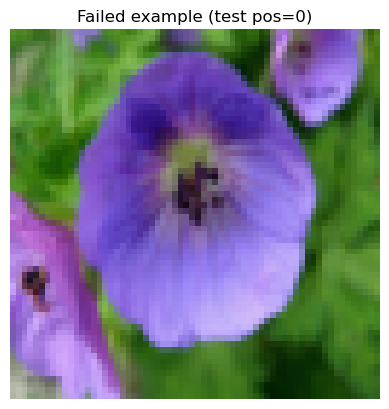

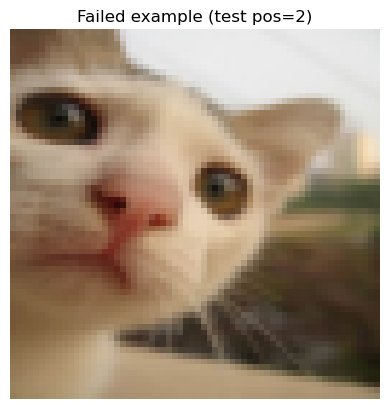

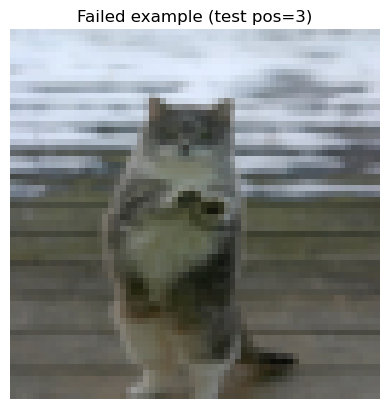

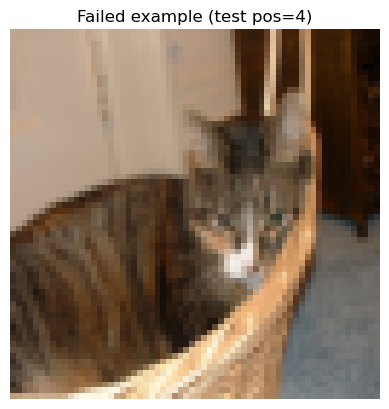

In [17]:
show = 4
for i in wrong_pos[:show]:
    img = X_orig[split + i] 
    plt.imshow(img)
    plt.title(f"Failed example (test pos={i})")
    plt.axis('off')
    plt.show()
